# Noisy Qubit Modeling Using the CUDA-Q Density Matrix Simulator

This notebook will familiarize the user with the CUDA-Q density-matrix-cpu simulator and walk the user through a few simple (but fundamental!) exercises to back out important intrinsic properties of a qubit. We will simulate and examine a few properties of a 'digital twin' of a qubit using a custom noise model acting on a single qubit. The following workflow will simulate the calibration of a single qubit gate to generate a $\pi$-pulse, frequency calibration, as well as important coherence properties of the qubit like $T_1$, $T_2$, and $T_2^*$.

There are many reasons a user would want to simulate this workflow! Imagine the user is granted access to a blackbox quantum processor with the ability to program basic quantum gates and do measurements. This setup is not unlike many popular QPU cloud providers that are publicly available, including many CUDA-Q hardware partners. In most cases, important characteristics like coherence, gate fidelities, and other qubit parameters are provided to the user. However, it is not uncommon that these quantities drift over the course of the day, or even over the course of an experiment. 

In many instances, the user may want to choose which qubits and gate fidelities will yield the highest fidelity for the user's specific application to achieve the highest fidelity results. In other instances, the user may want to simply verify that the user-measured qubit parameters match the provided parameters. Often times, a simple experiment which detects if a qubit's parameters has drifted (or in the worst case, gone bad) can save the user hours of debugging time down the road.

This notebook will model these parameters in a single qubit using the density-matrix-cpu simulator and will also give guidance on how to implement a custom noise model. A GPU accelerated version of this simulator will be released in the future as well which will provide significant performance enhancements. Custom noise models are an incredibly useful tool for characterizing and building intuition for an experimental setup. Noise and crosstalk terms within a Hamiltonian or Lindbladian can be easily implemented as Kraus operators which act on specific quantum channels and can accurately model and predict behavior of real, physical qubits. With a good noise model, anomalous qubit behavior can be readily diagnosed, saving time and access to the real quantum hardware.

We begin by importing `cudaq` with a few other python packages and a 'hidden' noise model from the `noise_parameters` file

In [1]:
import cudaq
import numpy as np
import matplotlib.pyplot as plt
from types import MethodType

from noise_parameters import *

## Amplitude calibration

In this exercise we will invoke a custom rx gate which models the ability to set the control pulse time and amplitude provided to the qubit. By varying either the pulse time or amplitude, we can smoothly evolve the qubit state around the X-axis. By measuring the qubit in the Z-basis, we should observe a Rabi oscillation. From this, we will be able to back out what amplitude and time should yield a $\pi$ pulse.

We define the function `noisy_rabi` which produces a single step of the Rabi experiment, setting an amplitude and time our custom rx gate.

In [2]:
## Set the backend to the DM-CPU simulator
cudaq.set_target('density-matrix-cpu')


## Noisy rabi oscillation
def noisy_rabi(time, amp, shots):
    kernel = cudaq.make_kernel()
    qubits = kernel.qalloc(1)

    ## Add the hidden noise model and define the custom_rx gate
    noise_model = hidden_noise_model(time)
    kernel.custom_rx = MethodType(custom_rx, kernel)

    ## Vary rx rotation angle
    kernel.custom_rx(time, amp, qubits[0])
    kernel.mz(qubits[0])
    counts = cudaq.sample(kernel, shots_count=shots, noise_model=noise_model)
    exp_z = counts.expectation()

    return exp_z

Let's do the experiment starting with an amplitude of 1 (arbitrary units) and a time window of 100 ns

In [3]:
# Amplitude
Amp = 1
# Time step
dt = 1
times = list(np.arange(0, 100, dt))

exp_z = []
for t in times:
    exp_z.append(noisy_rabi(t, Amp, 1000))

Text(0, 0.5, '<Z>')

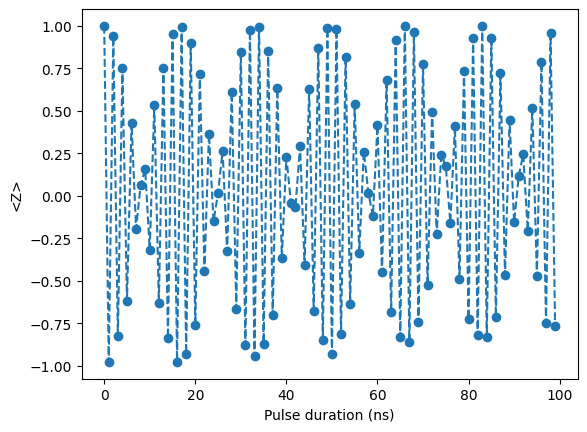

In [4]:
plt.plot(times, exp_z, '--o')
plt.xlabel('Pulse duration (ns)')
plt.ylabel('<Z>')

We see the qubit oscillating very quickly with the assigned parameters. Let's reduce the amplitude by a factor of 10. What happens? 

With a reduced amplitude we can clearly see the qubit evolving around the X-axis and we can calibrate the appropriate time it takes to apply a $\pi$ pulse. Notice there is a slight decay in the qubit amplitude from the excited state (Z=-1) to the ground state (Z=+1) due to $T_1$ decay.

You can also experiment with a longer time window or holding the length of the pulse constant and varying the amplitude.

## Frequency calibration

In this exercise we will model detecting if a qubit's frequency is calibrated properly. The frequency of the control pulse is required to match the qubit frequency to a high degree of accuracy. If it is detuned, the qubit will appear to precess around the Z-axis. The rate of precession is equal to the detuning frequency.

We will model this as an custom Identity gate (Id) which encodes the detuning error as a coherent Z rotation on the gate.

We will apply a H gate to initialize the qubit in the equator of Bloch sphere and observe a slight precession around the Z axis. One way this precession can be corrected is with an appropriately calibrated rz gate.

In [5]:
## Noisy precession
def noisy_precession(time, shots):
    kernel = cudaq.make_kernel()
    qubits = kernel.qalloc(1)
    noise_model = hidden_noise_model(time)
    kernel.Id = MethodType(Id, kernel)

    ## put qubit in equator
    kernel.h(qubits[0])

    ## Wait for time 'time'
    kernel.Id(time, qubits[0])

    ## Apply an Rz correction
    f_correction = 0.0
    kernel.rz(f_correction * time, qubits[0])

    ## Measure in y basis
    kernel.my(qubits[0])
    counts = cudaq.sample(kernel, shots_count=shots, noise_model=noise_model)
    exp_y = counts.expectation()

    return exp_y

In [6]:
exp_y = []
# Time step
dt = 1
times = list(np.arange(0, 100, dt))

for t in times:
    exp_y.append(noisy_precession(t, 1000))

(-1.0, 1.0)

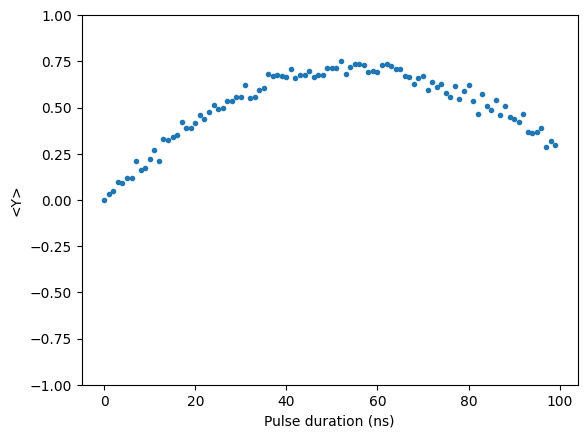

In [7]:
plt.plot(times, exp_y, '.')
plt.xlabel('Pulse duration (ns)')
plt.ylabel('<Y>')
plt.ylim([-1, 1])

We see the qubit slowly precessing about the Z-axis of the Bloch sphere indicating a slight detuning of the qubit frequency. Try adding a correction of $-\pi/250$ per ns.

## $T_1$ measurement

Let's do a simple $T_1$ measurement by exciting the qubit with an X gate, waiting for an Identity gate with time `time` and measuring the resulting Z population. Due to $T_1$ decay, the Z population will slowly relax to the ground state over time.

In [8]:
## T1 experiment
def T1_exp(time, shots):
    kernel = cudaq.make_kernel()
    qubits = kernel.qalloc(1)
    noise_model = hidden_noise_model(time)
    kernel.Id = MethodType(Id, kernel)

    ## excite qubit
    kernel.x(qubits[0])

    ## wait
    kernel.Id(time, qubits[0])

    ## measure in z basis
    kernel.mz(qubits[0])
    counts = cudaq.sample(kernel, shots_count=shots, noise_model=noise_model)
    exp_z = counts.expectation()

    return exp_z

In [9]:
exp_z = []
# Time step
dt = 50
end_time = 5000  #ns
times = list(np.arange(0, end_time, dt))
shots = 1000

for t in times:
    exp_z.append(T1_exp(t, 1000))

Text(0, 0.5, '<Z>')

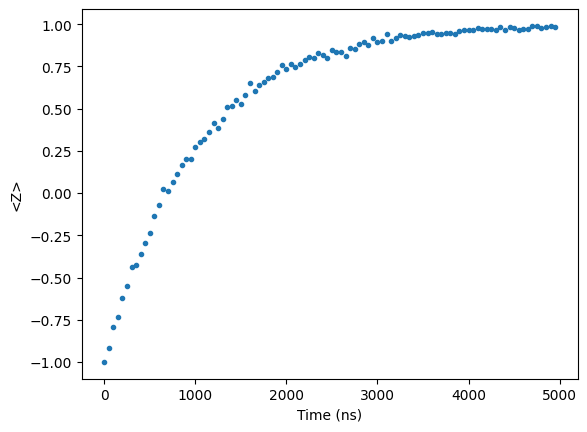

In [10]:
plt.plot(times, exp_z, '.')
plt.xlabel('Time (ns)')
plt.ylabel('<Z>')

## $T_2^*$ measurement

Let's look at an un-echoed $T_2$ measurement, aka $T_2^*$. This is one measure of a qubit's coherence. Often times a qubit can experience slow detuning noise, that is, noise that is constant over the course of a single experiment but varies over the course of repeated experiments. This slow noise can be cancelled out with standard control techniques like a Hahn echo and can boost the fidelity of an experiment when judiciously applied. Let's look at the un-echoed measurement first.

For this, we will prepare the qubit in the equator of the bloch sphere, wait for two time periods (you'll see why in the next section), and read out the qubit in the X-basis. 

In [11]:
## T2 experiment
def T2_star_exp(time, shots):
    kernel = cudaq.make_kernel()
    qubits = kernel.qalloc(1)
    noise_model = hidden_noise_model(time)
    kernel.Id = MethodType(Id, kernel)

    ## put qubit in equator
    kernel.h(qubits[0])

    ## wait
    kernel.Id(time, qubits[0])
    kernel.Id(time, qubits[0])

    kernel.mx(qubits[0])
    counts = cudaq.sample(kernel, shots_count=shots, noise_model=noise_model)
    exp_x = counts.expectation()

    return exp_x

In [12]:
exp_x = []
# Time step
dt = 15
end_time = 1500  #ns
times = list(np.arange(0, end_time, dt))
shots = 1000

for t in times:
    exp_x.append(T2_star_exp(t, 1000))

(-1.1, 1.1)

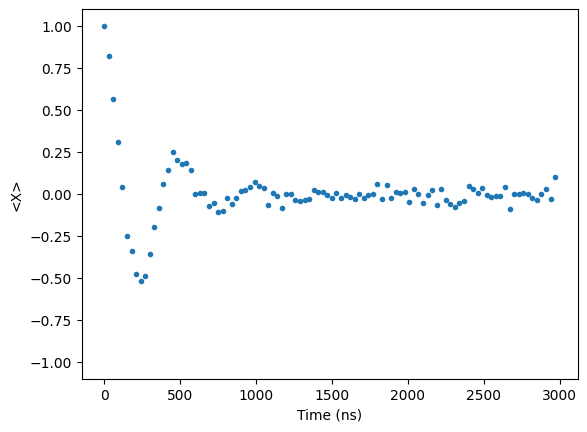

In [13]:
plt.plot([2 * t for t in times], exp_x, '.')
plt.xlabel('Time (ns)')
plt.ylabel('<X>')
plt.ylim([-1.1, 1.1])

As expected, we see a decay in coherence. We also see an additional oscillation from a constant, coherent Z error source. In many cases this Z noise can slowly vary over the course of the experiment which manifests as a reduced $T^2$ time. In the next experiment we will see we can cancel this noise source out by applying a simple X $\pi$ pulse.

## $T_2$ measurement

Let's repeat the previous experiment and simply add a $X_\pi$ pulse which will negate this noise source.

In [14]:
## T2 experiment
def T2_exp(time, shots):
    kernel = cudaq.make_kernel()
    qubits = kernel.qalloc(1)
    noise_model = hidden_noise_model(time)
    kernel.Id = MethodType(Id, kernel)

    ## put qubit in equator
    kernel.h(qubits[0])

    ## wait
    kernel.Id(time, qubits[0])
    kernel.x(qubits[0])
    kernel.Id(time, qubits[0])

    kernel.mx(qubits[0])
    counts = cudaq.sample(kernel, shots_count=shots, noise_model=noise_model)
    exp_x = counts.expectation()

    return exp_x

In [15]:
exp_x = []
# Time step
dt = 15
end_time = 1500  # ns
times = list(np.arange(0, end_time, dt))
shots = 1000

for t in times:
    exp_x.append(T2_exp(t, 1000))

(-1.1, 1.1)

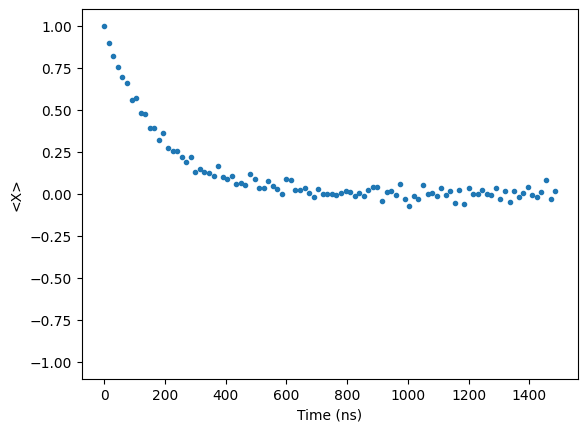

In [16]:
plt.plot(times, exp_x, '.')
plt.xlabel('Time (ns)')
plt.ylabel('<X>')
plt.ylim([-1.1, 1.1])

We see that adding the $\pi$ pulse successfully canceled the additional noise source!

## Building custom noise models and leveraging CUDA-Q's prebuilt noise models

Let's explore how to define custom noise models and apply them to gates. You can also leverage a variety of common noise models prebuilt in CUDA-Q. Noise models are implement as Kraus operators and channels acting on the density matrix. Earlier in the notebook we implemented a custom $T_1$ decay channel. Let's walk through the steps to implement this. We first define an error probability based on the gate length and a given $T_1$ time.



In [17]:
def error_prob(t, T1):
    error = 1 - np.exp(-t / T1)  #nanoseconds
    return error

Let's now define the Kraus operators which send the |1> state to the |0> state in the density matrix with a probability given by our function `error_prob`. These are compiled into a Kraus channel.

In [18]:
# Gate time
t = 100  #ns
T1 = 1000  #ns

t1_decay = error_prob(t, T1)
kraus_0 = np.array([[1.0, 0.0], [0.0, np.sqrt(1 - t1_decay)]],
                   dtype=np.complex128,
                   order='F')
kraus_1 = np.array([[0.0, np.sqrt(t1_decay)], [0.0, 0.0]],
                   dtype=np.complex128,
                   order='F')
kraus_chan = cudaq.KrausChannel([kraus_0, kraus_1])

We instantiate our noise_model and can now add our Kraus channel to the gate and qubit of our choice

In [19]:
noise_model = cudaq.NoiseModel()

## add noise to x
noise_model.add_channel("x", [0], t1_kraus(t, T1))

We can do a sanity check below

In [20]:
kernel = cudaq.make_kernel()
qubits = kernel.qalloc(1)
kernel.x(qubits[0])
kernel.mz(qubits[0])
counts = cudaq.sample(kernel, noise_model=noise_model)

print(counts.dump())

None
{ 0:94 1:906 }


CUDA-Q includes common noise channels like depolarizing noise, dephasing noise, amplitude damping and others here https://nvidia.github.io/cuda-quantum/latest/using/examples/noisy_simulation.html

In [21]:
noise_model = cudaq.NoiseModel()
bit_flip = cudaq.BitFlipChannel(1.0)
noise_model.add_channel('x', [0], bit_flip)


@cudaq.kernel
def kernel():
    qubit = cudaq.qubit()
    # Apply an X-gate to the qubit.
    # It will remain in the |1> state with a probability of `1 - p = 0.0`.
    x(qubit)
    # Measure.
    mz(qubit)


# Now we're ready to run the noisy simulation of our kernel.
# Note: We must pass the noise model to sample via keyword.
noisy_result = cudaq.sample(kernel, noise_model=noise_model)
print(noisy_result)

{ 0:1000 }

